# Exploration, dimensionality reduction and preparation of data from Crystallographic Open Database (COD) for input to machine learning models

## 1. Download and extract .cif files from COD .zip file


***NOTE: Some of the calculations in this notebook are parallelised across 8 cores since it's quite computationally intensive given that it processes the entire COD. Adjust the NUM_CORES parameter for your machine.***

In [95]:
import os
import ast
import pickle
import warnings
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from ase.io import read
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from collections import Counter
from pymatgen import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher
from functools import partial
from itertools import chain, combinations
from sklearn.metrics import matthews_corrcoef
from concurrent.futures import ProcessPoolExecutor
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# ASE has some warnings about space groups which can be safely ignored according to this StackExchange post:
# https://mattermodeling.stackexchange.com/questions/4457/ase-why-do-i-get-warnings-about-monoclinic-and-orthorhombic-not-being-inter
def ignore_ase_warnings(message, category, filename, lineno, file=None, line=None):
    return 'ase' not in filename
warnings.showwarning = ignore_ase_warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

In [3]:
# make sure you're in the repo's parent directory
os.getcwd()

'/home/trev/repos/materials-discovery'

In [ ]:
# download COD database
!wget http://www.crystallography.net/archives/cod-cifs-mysql.zip .

In [3]:
# Unzip the .zip file which produces two directories: 'mysql' (not needed) and 'cif'.
!unzip cod-cifs-mysql.zip > /dev/null
%rm -rf mysql

In [4]:
# The .cif files in the 'cif' directory are spread across and down many directories. Recursively find
# them all and place them in a new, single directory called 'cifs', and delete the old directory 'cif'.
!mkdir cifs
%cd cif/
!find . -name '*.cif' -exec mv {} ../cifs \;
%cd ..
%rm -rf cif
%rm cod-cifs-mysql.zip

# Create a .csv file called cifnames and populate it with all the .cif filenames in the 'cifs' directory
!touch cifnames.csv
%cd cifs
!ls > ../cifnames.csv
%cd ..

/home/trev/repos/materials-discovery/cif
/home/trev/repos/materials-discovery
/home/trev/repos/materials-discovery/cifs
/home/trev/repos/materials-discovery


In [32]:
# Set some constant variables for the notebook:
NUM_CORES = 12
DIRECTORY = 'cifs' # this directory was created with !mkdir cifs above

In [7]:
filenames = os.listdir(DIRECTORY)
paths_to_files = [DIRECTORY + '/' + filename for filename in os.listdir(DIRECTORY)]

## 2a. Check validity of .cif files

In [13]:
# Count how many .cif files are in the 'cifs' directory
%cd cifs
!ls | wc -l
%cd ..

/home/trev/repos/materials-discovery/cifs
501209
/home/trev/repos/materials-discovery


Let's now check all of these half a million .cif files to see if they all contain a valid crystal structure using the Structure class in pymatgen. 

***NOTE: This next cell takes about 1 hour on all 16 threads of my Ryzen 2700X. Adjust the NUM_CORES parameter for your machine.***

In [19]:
def is_cif_valid(cif):
    """
    Check that a .cif file has valid crystal structure.
    
    :param cif: Path to the .cif file
    :return: Returns None if the .cif file is valid, and returns the filename if not.
    """
    
    try:
        structure = Structure.from_file(cif)
        return None
    except Exception as e:
        return cif

# force multiprocessing to use certain number of cores
os.sched_setaffinity(0, range(NUM_CORES))

# Create a multiprocessing Pool
with Pool(processes=NUM_CORES) as pool:
    # Use tqdm to provide a progress bar
    # Use list() to force evaluation and preserve order
    faulty_files = list(tqdm(pool.imap(is_cif_valid, paths_to_files), total=len(paths_to_files)))

# Filter out None values to get a list of faulty files
paths_to_faulty_files = list(filter(None, faulty_files))

# save the list of faulty files 
with open('paths_to_faulty_files.pkl', 'wb') as f:
    pickle.dump(paths_to_faulty_files, f)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501209/501209 [1:04:41<00:00, 129.13it/s]


In [20]:
print(len(paths_to_faulty_files))

6447


Out of half a million files, only the structures of a few thousand of them can't be parsed, which is a pretty low failure rate.

In [22]:
for path_to_faulty_file in paths_to_faulty_files:
    os.remove(path_to_faulty_file)

See how many valid files are left:

In [5]:
len(os.listdir(DIRECTORY))

494762

The filenames and paths_to_files variables should also be updated to account for the deletions:

In [6]:
filenames = os.listdir(DIRECTORY)
paths_to_files = [DIRECTORY + '/' + filename for filename in os.listdir(DIRECTORY)]

## 2b. Check uniqueness of .cif files

Of the .cif files whose structures can be parsed, how many refer to the same structure? This is less easy to answer since materials turn up in multiple studies due to differences of experimental conditions, synthesis methods, or other contexts. It's also not easy to check directly because for n files, there are n(n-1)/2 unique pairings, which for half a million files, gives about 12 billion comparisons. It's not unreasonable though to just take a smaller sample and infer the amount of redundancy found in the sample to the population of all half a million .cif files.

Pairwise comparisons between files can be achieved with pymatgen's StructureMatcher. In addition, the pairwise comparison does not have to suffer directly from n(n-1)/2 scaling behaviour because as soon as a duplicate structure is found, it can be discarded to avoid redundant comparisons with said structure, as follows:

In [27]:
# Select a subset of files
some_files = paths_to_files[:10000]

# Create StructureMatcher with specified tolerances
matcher = StructureMatcher(ltol=0.2, stol=0.2, angle_tol=2)

# List to store unique structures and corresponding files
unique_structures = []
unique_files = []

def check_structure(file):
    try:
        structure = Structure.from_file(file)
        # Check if the structure matches any of the unique structures found so far
        for unique in unique_structures:
            if matcher.fit(structure, unique):
                # If a match is found, return None
                return None
        # If no match is found, return the structure
        return (structure, file)
    except Exception as e:
        return None

# bind process to a subset of cores
os.sched_setaffinity(0, range(NUM_CORES))

# create a multiprocessing Pool
with Pool(processes=NUM_CORES) as pool:
    results = list(tqdm(pool.imap(check_structure, some_files), total=len(some_files)))

# Filter out None values and add structures and files to unique lists
for result in results:
    if result is not None:
        unique_structures.append(result[0])
        unique_files.append(result[1])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:56<00:00, 85.78it/s]


In [29]:
print(len(unique_structures))
print(len(unique_files))

10000
10000


## 3. Create dataframe showing which .cif files contain which elements

This section extracts the number of times each element occurs in each .cif file. It does not count their relative proportions as per the chemical formulae; it just assigns a 1 for "yes, this .cif file contains hydrogen", or 0 for no, etc.

***NOTE: The entire set of 500,000 or so .cif files takes about 7 hours to process when parallelised across 8 threads.***

In [31]:
elements = {1:"H",2:"He",3:"Li",4:"Be",5:"B",6:"C",7:"N",8:"O",9:"F",10:"Ne",
11:"Na",12:"Mg",13:"Al",14:"Si",15:"P",16:"S",17:"Cl",18:"Ar",19:"K",20:"Ca",
21:"Sc",22:"Ti",23:"V",24:"Cr",25:"Mn",26:"Fe",27:"Co",28:"Ni",29:"Cu",30:"Zn",
31:"Ga",32:"Ge",33:"As",34:"Se",35:"Br",36:"Kr",37:"Rb",38:"Sr",39:"Y",40:"Zr",
41:"Nb",42:"Mo",43:"Tc",44:"Ru",45:"Rh",46:"Pd",47:"Ag",48:"Cd",49:"In",50:"Sn",
51:"Sb",52:"Te",53:"I",54:"Xe",55:"Cs",56:"Ba",57:"La",58:"Ce",59:"Pr",60:"Nd",
61:"Pm",62:"Sm",63:"Eu",64:"Gd",65:"Tb",66:"Dy",67:"Ho",68:"Er",69:"Tm",70:"Yb",
71:"Lu",72:"Hf",73:"Ta",74:"W",75:"Re",76:"Os",77:"Ir",78:"Pt",79:"Au",80:"Hg",
81:"Tl",82:"Pb",83:"Bi",84:"Po",85:"At",86:"Rn",87:"Fr",88:"Ra",89:"Ac",90:"Th",
91:"Pa",92:"U",93:"Np",94:"Pu",95:"Am",96:"Cm",97:"Bk",98:"Cf",99:"Es",100:"Fm",
101:"Md",102:"No",103:"Lr",104:"Rf",105:"Db",106:"Sg",107:"Bh",108:"Hs",109:"Mt",
110:"Ds",111:"Rg",112:"Cn",113:"Nh",114:"Fl",115:"Mc",116:"Lv",117:"Ts",118:"Og",
}

In [40]:
def analyse_file(filename, directory):
    try:
        atoms = read(f'{directory}/{filename}')
        atomic_numbers = list(set(atoms.get_atomic_numbers()))
        row = dict.fromkeys(elements.keys(), 0)  # initialize keys directly from elements
        for num in atomic_numbers:
            if num in row:  # check if num is a valid key (this is optional)
                row[num] = 1
        return (filename, row)
    except Exception as e:
        os.remove(f'{directory}/{filename}')        
        print(f'File {filename} failed: {e}')
        return (filename, None)


df = pd.DataFrame(0, columns=elements.keys(), index=filenames)        

process_file_in_directory = partial(analyse_file, directory=DIRECTORY)

pool = Pool(NUM_CORES)

# wrap pool.imap with tqdm for a progress bar
results = list(tqdm(pool.imap(process_file_in_directory, filenames), total=len(filenames)))

pool.close()
pool.join()

successful_results = [result for result in results if result[1] is not None]
indices = [result[0] for result in successful_results]
data = [result[1] for result in successful_results]
df = pd.DataFrame(data, index=indices)

df.to_csv('atomic-numbers-in-cifs.csv')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.69it/s]


In [170]:
df = pd.read_csv('atomic-numbers-in-cifs.csv', index_col=0)
df = df.drop('0', axis=1)

In [171]:
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118
7202035.cif,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4318965.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2238511.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7121865.cif,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007483.cif,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007991.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2005370.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8102810.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7243130.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This dataframe has the atomic number in the columns, and the .cif file name in the rows.

## 4. Data visualisation

### 4a. How many unique elements tend to be in each compound

Firstly, let's look at the distribution of how many elements are in each .cif file:

In [74]:
num_unique_elements_dist = df.sum(axis=1).value_counts().sort_index()
num_unique_elements_dist

1       2548
2      16363
3      56243
4     109893
5     144201
6     100569
7      43765
8      13303
9       3014
10       480
11        37
Name: count, dtype: int64

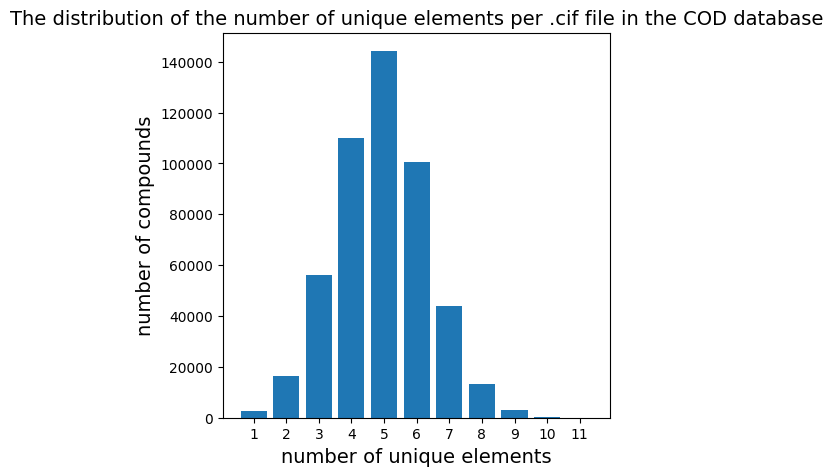

In [75]:
barchart0 = plt.figure(figsize=(5,5))
ax0 = barchart0.add_subplot(111)
ax0.bar(num_unique_elements_dist.index, num_unique_elements_dist.values)
ax0.set_title('The distribution of the number of unique elements per .cif file in the COD database', fontsize=14)
ax0.set_xlabel('number of unique elements', fontsize=14)
ax0.set_ylabel('number of compounds', fontsize=14)
ax0.set_xticks(np.arange(1,12,1))
ax0.tick_params(axis='both',labelsize=10)
plt.show()

### 4b. How often does each element turn up

Let's look at how often each element appears in the database:

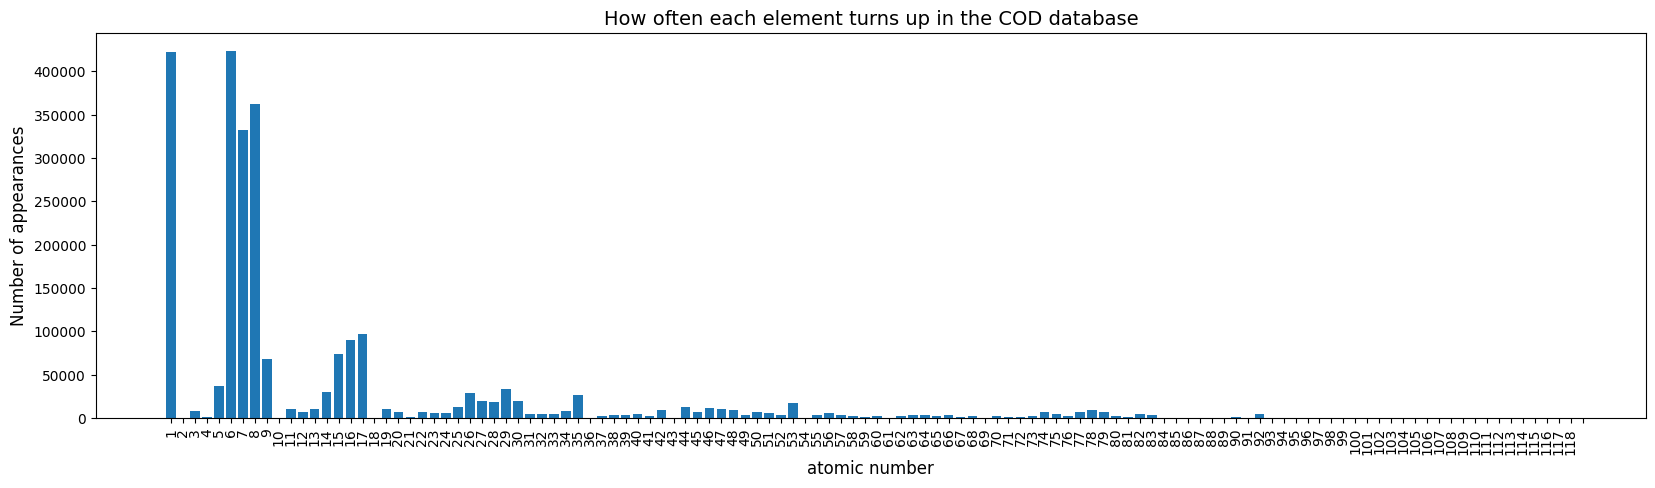

In [76]:
atomic_numbers = df.sum(axis=0).index
atomic_numbers_freq = df.sum(axis=0).values

# Plot the barchart 
barchart1 = plt.figure(figsize=(20,5))
ax1 = barchart1.add_subplot(111)
ax1.bar(atomic_numbers, atomic_numbers_freq)
ax1.set_title('How often each element turns up in the COD database', fontsize=14)
ax1.set_xlabel('atomic number', fontsize=12)
ax1.set_ylabel('Number of appearances', fontsize=12)
ax1.tick_params(axis='both', which='major',labelsize=10)
plt.xticks(np.arange(0,119,1), rotation='vertical')
plt.show()

And on a log scale:

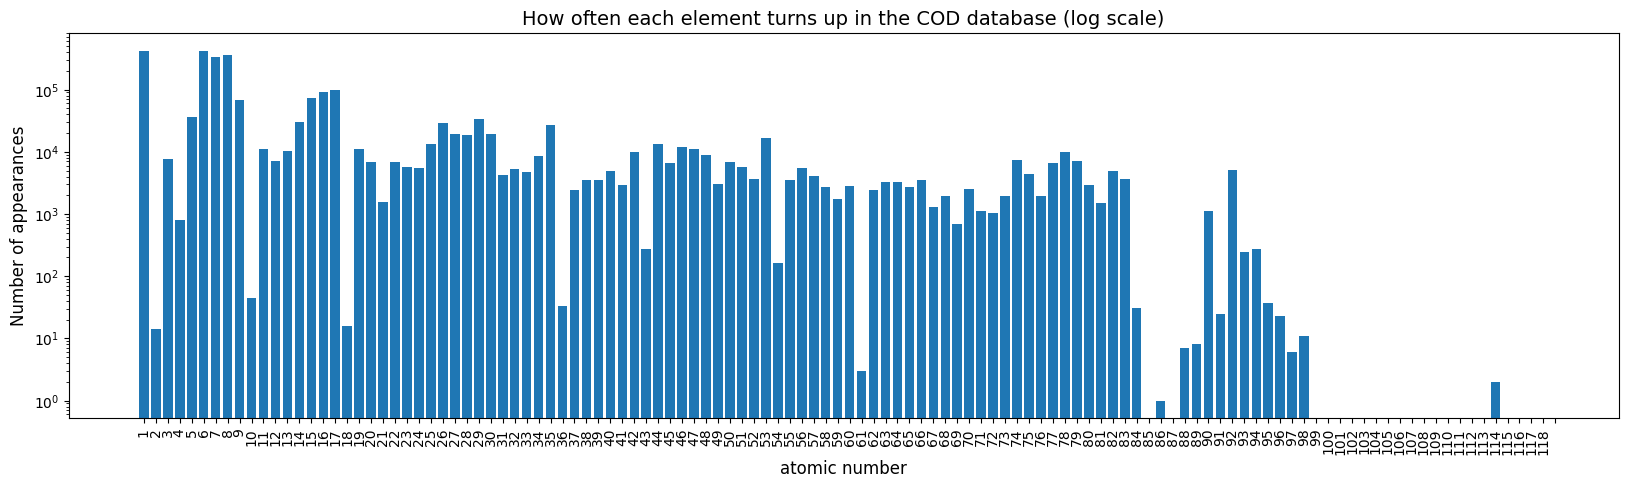

In [77]:
atomic_numbers = df.sum(axis=0).index
atomic_numbers_freq = df.sum(axis=0).values

# Plot the barchart 
barchart1 = plt.figure(figsize=(20,5))
ax1 = barchart1.add_subplot(111)
ax1.bar(atomic_numbers, atomic_numbers_freq)
ax1.set_title('How often each element turns up in the COD database (log scale)', fontsize=14)
ax1.set_xlabel('atomic number', fontsize=12)
ax1.set_ylabel('Number of appearances', fontsize=12)
ax1.tick_params(axis='both', which='major',labelsize=10)
plt.xticks(np.arange(0,119,1), rotation='vertical')
plt.yscale('log')
plt.show()

So there are usually somewhere between 3 to 7 elements per .cif file, and most of them tend to involve the typical organic elements such as H, C, N, and O.

The analysis that follows can't deal with missing values (PCA and clustering in section 5), so I'll drop all columns that sum to zero (i.e. for elements that don't occur at all in the data.)

In [174]:
df = df.loc[:, (df != 0).any(axis=0)]
df.to_csv('atomic-numbers-in-cifs-reduced.csv')

In [173]:
df.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61',
       '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73',
       '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '86',
       '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98',
       '114'],
      dtype='object')

In [149]:
# update the list of atomic numbers and their frequencies according the the new df columns.
atomic_numbers = df.sum(axis=0).index
atomic_numbers_freq = df.sum(axis=0).values

### 4c. How do the elements correlate with eachother: Brute force intuitive approach for elements 1 to 9 inclusive.

A straightforward function to pick out the filenames containing certain elements and excluding others is a useful way to build some intuition of where in the periodic table most of the elements are occurring in the database.

In [87]:
def get_cif_filenames(df, atomic_numbers, include_all=False, exclude_others=True):
    
    mask = df.columns.isin(atomic_numbers)
    notmask = ~mask
    
    if include_all == True and exclude_others == True:    
        filenames_mask = (df.loc[:, mask].eq(1).all(axis=1)) & (df.loc[:, notmask].eq(0).all(axis=1))
        filenames = list(filenames_mask[filenames_mask].index)
        return filenames
    
    elif include_all == False and exclude_others == True:
        filenames_mask = (df.loc[:, mask].eq(1).any(axis=1)) & (df.loc[:, notmask].eq(0).all(axis=1))
        filenames = list(filenames_mask[filenames_mask].index)
        return filenames

    elif include_all == True and exclude_others == False:
        filenames_mask = (df.loc[:, mask].eq(1).all(axis=1))
        filenames = list(filenames_mask[filenames_mask].index)
        return filenames
    
    elif include_all == False and exclude_others == False:
        filenames_mask = (df.loc[:, mask].eq(1).any(axis=1))
        filenames = list(filenames_mask[filenames_mask].index)
        return filenames
    
    else:
        return None

    
def get_num_cif_files(df, atomic_numbers, include_all=False, exclude_others=True):
    
    return len(get_cif_filenames(df, atomic_numbers, include_all, exclude_others))

Since the atomic numbers 1 - 9 inclusive are generally fairly abundant in the database compared to the other elements, it's not too silly to use a brute force method to work out how many .cif files would be obtained by filtering by all possible subsets. (Doing this for all Z up to 100 or so would result in a combinatorial explosion; 9 choose 5 {the biggest combination} is 126 which is not large.)

In [88]:
# atomic_number_range for this direct analysis
atomic_number_range = [str(Z) for Z in range(1, 10)]

# create the subsets of atomic numbers (n choose r, where n and r vary from 1 to 9)
subsets = list(chain(*map(lambda x: combinations(atomic_number_range, x), range(2, len(atomic_number_range)+1))))

def process_subset(subset):
    """
    #######################
    """

    # Create a dictionary with default value 0
    row = dict.fromkeys(atomic_number_range, 0)
    
    # Update the dictionary with the subset (set value to 1)
    for letter in subset:
        row[letter] = 1

    row['num_files'] = get_num_cif_files(df, subset, include_all=False, exclude_others=True)
    
    return row

# Create a multiprocessing Pool
with Pool(NUM_CORES) as p:
    # Wrap p.imap with tqdm for a progress bar
    rows = list(tqdm(p.imap(process_subset, subsets), total=len(subsets)))

# Convert the list of dictionaries to a DataFrame
num_files_df = pd.DataFrame(rows, columns=['num_files'] + atomic_number_range)
num_files_df.sort_values('num_files', ascending=False)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:35<00:00, 14.26it/s]


,num_files,1,2,3,4,5,6,7,8,9
501,89777,1,1,1,1,1,1,1,1,1
499,89768,1,0,1,1,1,1,1,1,1
497,89581,1,1,1,0,1,1,1,1,1
482,89572,1,0,1,0,1,1,1,1,1
498,88372,1,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
8,37,0,1,1,0,0,0,0,0,0
35,36,0,0,0,0,0,0,0,1,1
10,30,0,1,0,0,1,0,0,0,0
13,26,0,1,0,0,0,0,0,1,0


While 90275 files that contain any combination of elements 1 to 9 inclusive sounds like a reasonable dataset, the sparsity of the input space is more sensibly measured by taking some quantity raised to the power of the number of elements:

In [89]:
num_files_df['total_num_elements'] = num_files_df[atomic_number_range].apply(lambda row: sum(row), axis=1)
num_files_df['sparsity'] = np.exp(num_files_df['total_num_elements']) / num_files_df['num_files']
num_files_df = num_files_df.sort_values('sparsity', ascending=True)
num_files_df

,num_files,1,2,3,4,5,6,7,8,9,total_num_elements,sparsity
172,74331,1,0,0,0,0,1,1,1,0,4,0.000735
59,19281,1,0,0,0,0,1,0,1,0,3,0.001042
315,82225,1,0,0,0,0,1,1,1,1,5,0.001805
311,77887,1,0,0,0,1,1,1,1,0,5,0.001905
297,75328,1,0,1,0,0,1,1,1,0,5,0.001970
...,...,...,...,...,...,...,...,...,...,...,...,...
461,462,1,1,1,1,1,0,0,1,1,7,2.373665
487,388,0,1,1,1,1,0,1,1,1,7,2.826374
460,383,1,1,1,1,1,0,1,0,1,7,2.863272
500,1004,0,1,1,1,1,1,1,1,1,8,2.969082


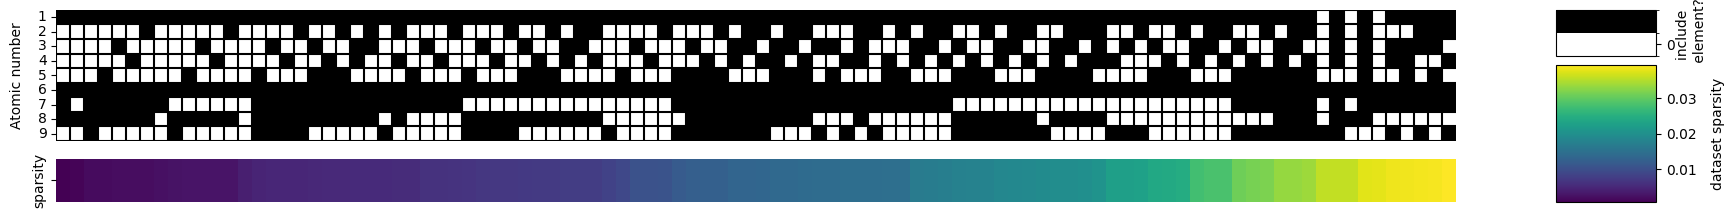

In [90]:
# Select first 100 rows, i.e. the least sparse. (All 500 is too many to visualise)
num_files_df_subset = num_files_df[:100]
binary_df = num_files_df_subset[['1', '2', '3', '4', '5', '6', '7', '8', '9']]
continuous_df = num_files_df_subset[['sparsity']]

fig = plt.figure(figsize=(20, 2.5))

# Create a gridspec object for heatmaps
gs_heatmaps = gridspec.GridSpec(2, 1, height_ratios=[3, 1], width_ratios=[1], left=0.1, right=0.8, wspace=0.05)

# Binary heatmap
ax1 = plt.subplot(gs_heatmaps[0])
sns.heatmap(binary_df.T, cmap='binary', cbar=False, yticklabels=True, xticklabels=False, ax=ax1)
ax1.set_ylabel('Atomic number', rotation=90, labelpad=10)  # Add y-axis label
plt.setp(ax1.get_yticklabels(), rotation=0)  # Rotate y-tick labels

# Add gridlines
ax1xlimits = ax1.get_xlim()
ax1.hlines([i for i in range (0, len(atomic_number_range)+1)], ax1xlimits[0], ax1xlimits[1], color='black')
ax1ylimits = ax1.get_ylim()
ax1.vlines([i for i in range(0, len(binary_df))], ax1ylimits[0], ax1ylimits[1], color='black')

# Continuous heatmap
ax2 = plt.subplot(gs_heatmaps[1])
sns.heatmap(continuous_df.T, cmap='viridis', cbar=False, yticklabels=True, xticklabels=False, ax=ax2)

# Create a gridspec object for colorbars
gs_colorbars = gridspec.GridSpec(2, 1, height_ratios=[1, 3], left=0.85, right=0.9, hspace=0.1)

# Binary colorbar (1, 0)
ax3 = plt.subplot(gs_colorbars[0])
cmap = mcolors.ListedColormap(['white', 'black'])
bounds = [0, 0.5, 0.6]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                   cax=ax3,
                   ticks=[0.25, 0.75],
                   orientation='vertical')
cb1.set_label('include \n element?', rotation=90, labelpad=1)
cb1.set_ticklabels(['0', '1'])

# Colorbar for sparsity data
ax4 = plt.subplot(gs_colorbars[1])
cbar = plt.colorbar(ax2.collections[0], cax=ax4, use_gridspec=True)
cbar.set_label('dataset sparsity', rotation=90, labelpad=10)
plt.savefig('sparsity-by-atomic-number-subset.png')
plt.show()

The least sparse subset of .cif files we could choose according to this analysis consists of those containing any combination of elements with atomic numbers 1,6,7, and 8 at the exclusion of all other elements, which is not too surprising.

### 4d. How do the elements correlate with eachother: correlation matrix approaches for elements 1 to 84

Let's plot the Pearson correlation matrix to see which elements co-occur: (remember we've not extracted chemical formulae, just 1 or 0 for whether each element turns up)

In [91]:
# Pearson correlation matrix
corr_matrix = df.corr(method='pearson')

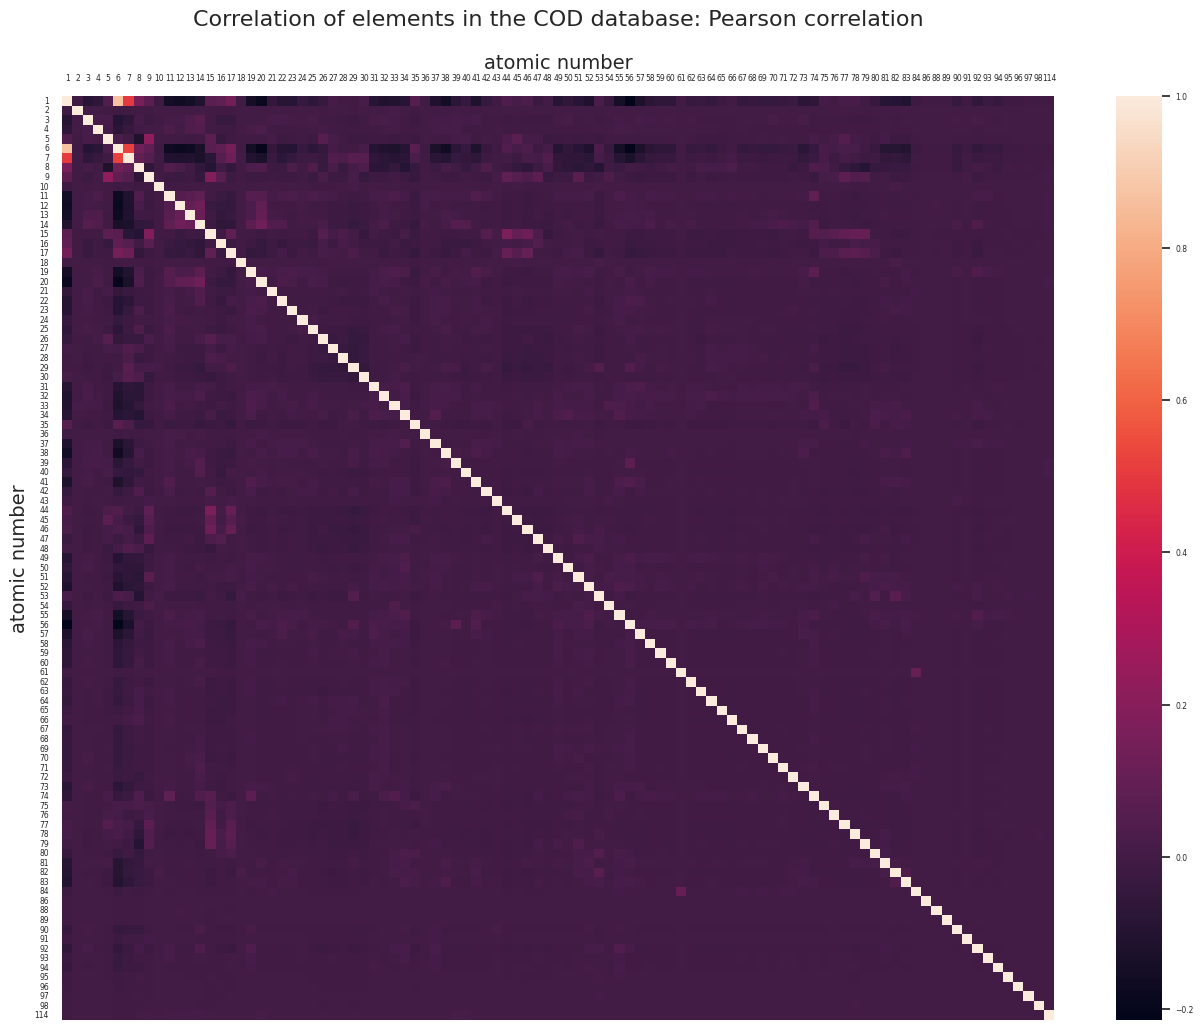

In [187]:
heatmap = plt.figure(figsize=(16, 12))
ax5 = sns.heatmap(corr_matrix)
sns.set(font_scale=0.45)
ax5.set_ylabel('atomic number', fontsize=14)
ax5.set_xlabel('')  # Empty xlabel
ax5.xaxis.tick_top()  # x axis on top
ax5.xaxis.set_label_position('top')  # x axis label on top
ax5.set_xlabel('atomic number', fontsize=14)
ax5.set_title('Correlation of elements in the COD database: Pearson correlation', fontsize=16, pad=20)
ax5.tick_params(axis='x', which='both', bottom=False, top=False)  # remove x-axis ticks
plt.savefig('pearson-correlation.png')
plt.show()

This is actually a red flag because while there's strong correlation around the Carbon (Z=6) region, Oxygen (Z=8) does not appear very prominently.

Since the data is binary ("does this element appear in this .cif file; yes or no"), it's better to use metrics that are more suitable for associations in binary data, such as the Jaccard index or the Matthews correlation coefficient:

In [96]:
def jaccard_similarity(column1, column2):
    intersection = np.logical_and(column1, column2)
    union = np.logical_or(column1, column2)
    similarity = intersection.sum() / float(union.sum())
    return similarity

def calculate_metrics(pair):
    col1, col2 = pair
    return {
        'pair': pair,
        'jaccard': jaccard_similarity(df[col1], df[col2]),
        'mcc': matthews_corrcoef(df[col1], df[col2]),
    }

# Jaccard index matrix
jaccard_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Matthews correlation coefficient matrix
mcc_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Compute pairwise metrics for each pair of columns
with ProcessPoolExecutor(max_workers=NUM_CORES) as executor:
    # Wrap combinations(df.columns, 2) with tqdm for a progress bar
    results = list(tqdm(executor.map(calculate_metrics, combinations(df.columns, 2)), total=int(len(df.columns)*(len(df.columns)-1)/2)))

for result in results:
    col1, col2 = result['pair']
    jaccard_matrix.loc[col1, col2] = result['jaccard']
    mcc_matrix.loc[col1, col2] = result['mcc']

# Copy lower triangle to upper triangle to make the matrices symmetric
for df_ in [jaccard_matrix, mcc_matrix]:
    df_.update(df_.transpose())
    
np.fill_diagonal(jaccard_matrix.values, 1)
np.fill_diagonal(mcc_matrix.values, 1)

jaccard_matrix = jaccard_matrix.apply(pd.to_numeric)
mcc_matrix = mcc_matrix.apply(pd.to_numeric)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4656/4656 [02:14<00:00, 34.67it/s]


Let's plot the pairwise matrices showing the Jaccard index and Matthews correlation coefficient:

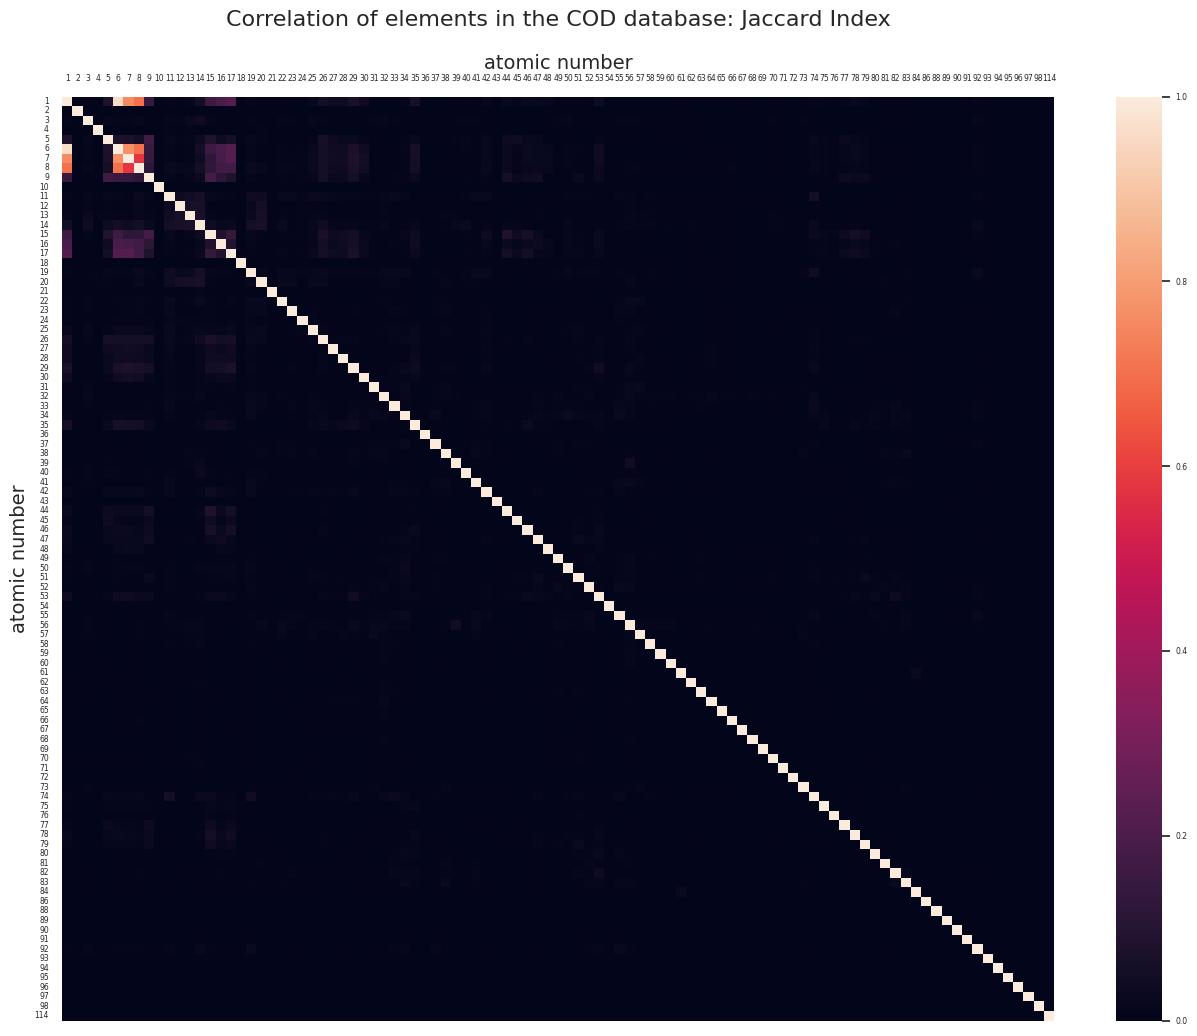

In [186]:
heatmap = plt.figure(figsize=(16, 12))
ax6 = sns.heatmap(jaccard_matrix)
sns.set(font_scale=0.5)
ax6.set_ylabel('atomic number', fontsize=14)
ax6.set_xlabel('')  # Empty xlabel
ax6.xaxis.tick_top()  # x axis on top
ax6.xaxis.set_label_position('top')  # x axis label on top
ax6.set_xlabel('atomic number', fontsize=14)
ax6.set_title('Correlation of elements in the COD database: Jaccard Index', fontsize=16, pad=20)
ax6.tick_params(axis='x', which='both', bottom=False, top=False)  # remove x-axis ticks
plt.savefig('jaccard-indices.png')
plt.show()

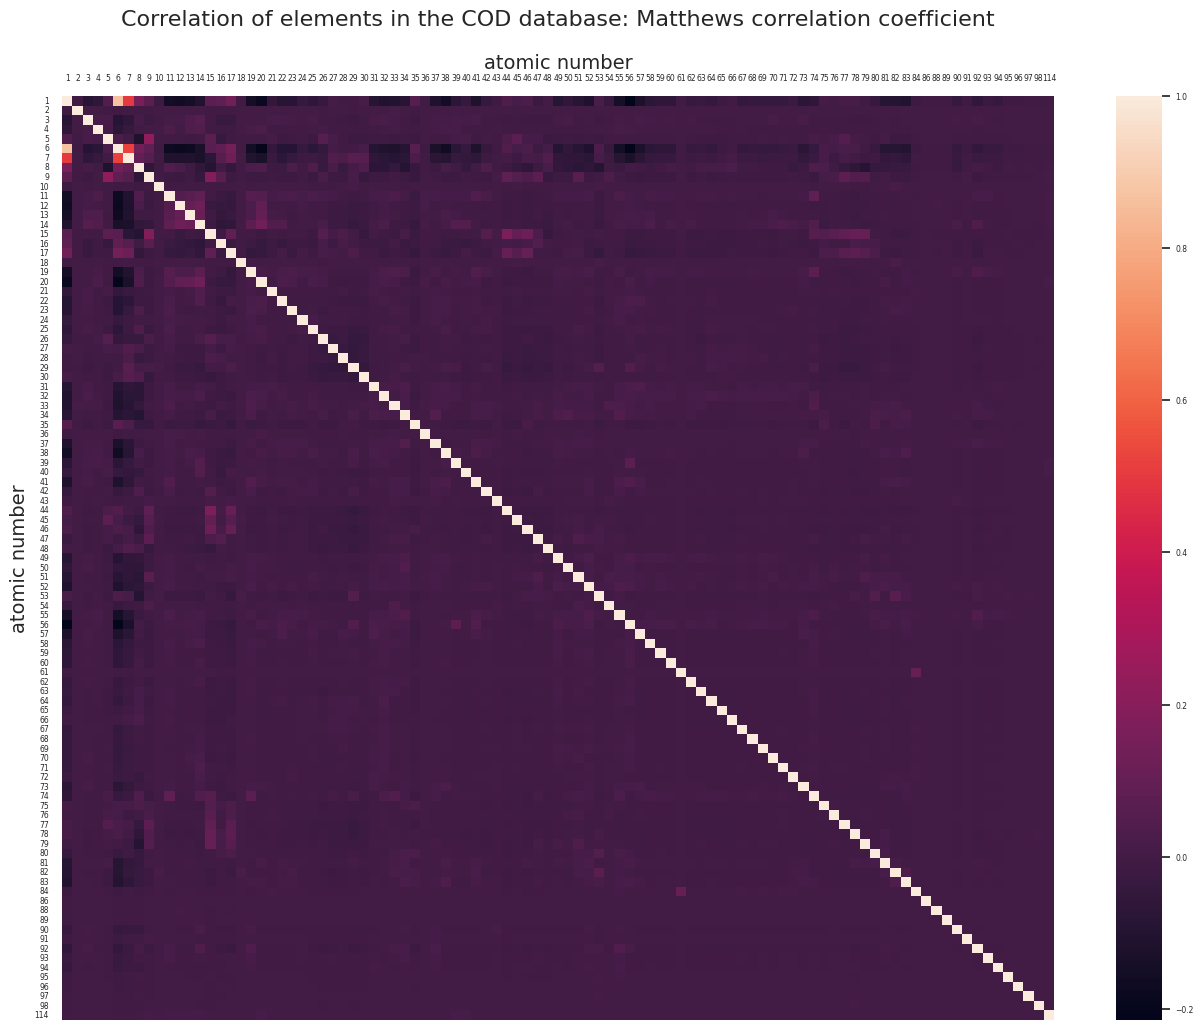

In [185]:
heatmap = plt.figure(figsize=(16, 12))
ax4 = sns.heatmap(mcc_matrix)
sns.set(font_scale=0.5)
ax4.set_ylabel('atomic number', fontsize=14)
ax4.set_xlabel('')  # Empty xlabel
ax4.xaxis.tick_top()  # x axis on top
ax4.xaxis.set_label_position('top')  # x axis label on top
ax4.set_xlabel('atomic number', fontsize=14)
ax4.set_title('Correlation of elements in the COD database: Matthews correlation coefficient', fontsize=16, pad=20)
ax4.tick_params(axis='x', which='both', bottom=False, top=False)  # remove x-axis ticks
plt.savefig('matthews-correlation.png')
plt.show()

## 5. Dimensionality reduction

The correlation matrix is generally quite sparse and highly concentrated in the organic (near Carbon) region, so it makes sense to use a systematic approach to pick which elements to focus on to reduce the sparsity of the input space. It would be nice, but totally implausible, to do a brute-force calculation of which elements to pick. From 84 elements, the number of possible subsets of n elements is 84 choose n, which for n=42 equals 1.6789105e+24. Best to use something more clever and less ridiculous.

## 5a. Principal component analysis and agglomerative clustering to pick the least sparse subset of elements for analysis: visualisation over 2 PCA components

Principal component analysis is a good way to reduce the dimensionality of the data, followed by agglomerative clustering to pick a subset of elements. This is easy to visualise in 2 dimensions (2 principal components), picking some arbitrary number of clusters:

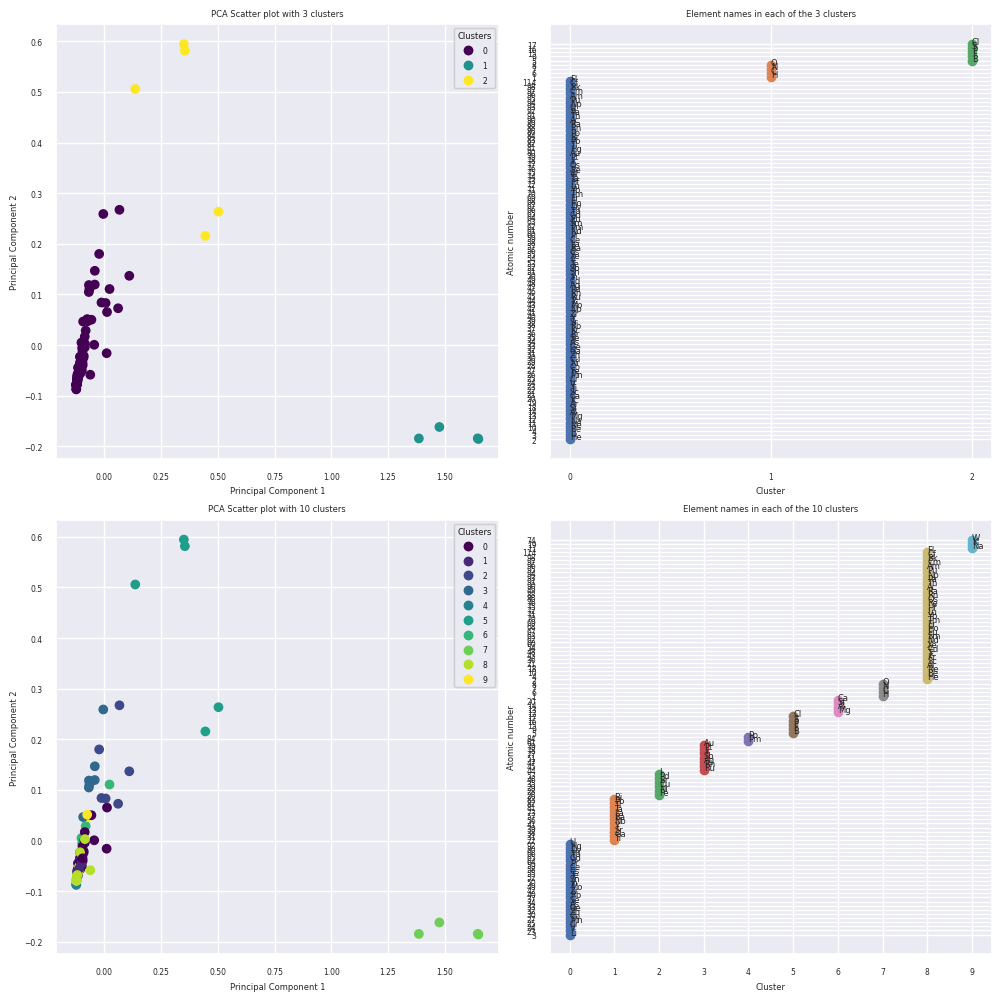

In [99]:
n_clusters_list = [3, 10]
fig, axs = plt.subplots(len(n_clusters_list), 2, figsize=(10, 5*len(n_clusters_list)))

for i, n_clusters in enumerate(n_clusters_list):
    cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = cluster.fit_predict(jaccard_matrix)
    
    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(jaccard_matrix)

    # Create a scatter plot
    scatter = axs[i, 0].scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, cmap='viridis')

    # Add legend, title and labels
    legend1 = axs[i, 0].legend(*scatter.legend_elements(), title="Clusters")
    axs[i, 0].add_artist(legend1)
    axs[i, 0].set_title(f'PCA Scatter plot with {n_clusters} clusters')
    axs[i, 0].set_xlabel('Principal Component 1')
    axs[i, 0].set_ylabel('Principal Component 2')

    # For each cluster, plot the column names that are included in the cluster
    for j in range(n_clusters):
        column_names = jaccard_matrix.columns[cluster_labels == j]
        element_names = [elements[int(name)] for name in column_names]  # Get element names
        axs[i, 1].scatter(np.repeat(j, len(column_names)), column_names, label=f'Cluster {j+1}')  # Use column names for y-values
        for k, element_name in enumerate(element_names):
            axs[i, 1].text(j, column_names[k], element_name)  # Use element names for labels

    axs[i, 1].set_title(f'Element names in each of the {n_clusters} clusters')
    axs[i, 1].set_xlabel('Cluster')
    axs[i, 1].set_ylabel('Atomic number')
    axs[i, 1].set_xticks(range(n_clusters))  # Display integer labels on x-axis

plt.tight_layout()
plt.show()


It's interesting to note that the triplet C, H, O, and N stick together in the same cluster in all these cases. This confirms one's intuition about organic chemistry and the abundance of C in the world.

## 5b. Principal component analysis and agglomerative clustering to pick the least sparse subset of elements for analysis (systematic)

Now that some intuition has been achieved through visualisation, let's now proceed to do a more systematic grid search over the number of PCA components and clusters, and investigate the number of entries in the original dataframe that such clusters would result in. This will help to find the richest subset of input data to minimise input sparsity.

In [158]:
def cluster_jaccard_matrix(jaccard_matrix, n_clusters, n_components):
    # PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(jaccard_matrix)
    
    # hierarchical clustering on the reduced data
    cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = cluster.fit_predict(reduced_data)

    # dictionary mapping cluster indices to column names
    cluster_dict = {}
    for j in range(n_clusters):
        column_names = jaccard_matrix.columns[cluster_labels == j]
        cluster_dict[j] = list(column_names)
    
    return cluster_dict


def count_rows_with_elements(df, elements):
    
    # Create a mask for the columns specified
    mask_elements = df.columns.isin(elements)

    # Create a mask for the other columns
    mask_others = ~mask_elements

    # Check if *any* of the elements in the specified columns are 1 and *all* the elements in the other columns are 0
    mask_rows = (df.loc[:, mask_elements].eq(1).any(axis=1)) & (df.loc[:, mask_others].eq(0).all(axis=1))

    # Sum the number of rows that fulfill these conditions
    count = mask_rows.sum()

    return count


def process_clusters_components(args):
    n_clusters, n_components = args
    clusters_dict = cluster_jaccard_matrix(jaccard_matrix, n_clusters, n_components)
    rows = []
    for cluster_index, atomic_numbers in clusters_dict.items():
        num_cif_files = count_rows_with_elements(df, atomic_numbers)
        
        dimensions = len(atomic_numbers)
        
        row = [str(atomic_numbers), # string with atomic numbers of elements in the cluster
               dimensions,          # how many elements are in the cluster
               n_clusters,          # how many clusters were used in the agglomerative cluster algorithm
               n_components,        # how many components were used in the PCA
               num_cif_files,       # how many .cif files (i.e. rows in the original dataframe) that contain the elements referred to in atomic_numbers
               np.exp(dimensions) / num_cif_files,  # a measure of sparsity: the exponential of the number of unique elements divided by number of cif files containing those elements
        ]
        
        rows.append(row)
    return rows


# define the grid for number of PCA components and number of clusters (30 x 30  grid)
n_clusters_components = list(product(range(1, 31), repeat=2))

with multiprocessing.Pool(NUM_CORES) as p:
    results = list(tqdm(p.imap_unordered(process_clusters_components, n_clusters_components), total=len(n_clusters_components)))

# Flatten the list of results to add them to the DataFrame
results = [row for sublist in results for row in sublist]

df_ = pd.DataFrame(results, columns=['atomic_numbers', 'num_elements', 'n_clusters', 'n_components', 'num_cif_files', 'sparsity'])

df_['atomic_numbers'] = df_['atomic_numbers'].apply(ast.literal_eval)

for index, row in df_.iterrows():
    for atomic_number in row['atomic_numbers']:
        df_.loc[index, str(atomic_number)] = int(1)
df_.loc[:, atomic_numbers] = df_.loc[:, atomic_numbers].fillna(0).astype(int)

df_[atomic_numbers] = df_[atomic_numbers].astype(int)
df_ = df_.drop('atomic_numbers', axis=1)
df_ = df_.sort_values('sparsity', ascending=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [15:52<00:00,  1.06s/it]


In [159]:
df_

,num_elements,n_clusters,n_components,num_cif_files,sparsity,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,88,89,90,91,92,93,94,95,96,97,98,114
2323,4,12,29,74331,7.345273e-04,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1132,4,9,7,74331,7.345273e-04,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2568,4,13,18,74331,7.345273e-04,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9440,4,25,18,74331,7.345273e-04,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2581,4,13,20,74331,7.345273e-04,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,97,1,7,490416,2.728978e+36,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
25,97,1,26,490416,2.728978e+36,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
10,97,1,12,490416,2.728978e+36,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
22,97,1,23,490416,2.728978e+36,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [160]:
# drop the PCA components and number of clusters since they're just artefacts of the grid search for the dimensionality reduction#
df_ = df_.drop(['n_clusters','n_components'], axis=1)
df_.drop_duplicates(inplace=True)
df_ = df_.reset_index(drop=True)
df_.to_csv('element-masks.csv', index=False)

## 6. Generate file lists based on choices of which elements to include

By saving the dataframe df_ as a .csv file, it can be reopened in a Python module or different Jupyter notebook in order to select the input files for an ML model by selecting a row. Something like the below:

In [175]:
df_ = pd.read_csv('element-masks.csv')
df = pd.read_csv('atomic-numbers-in-cifs-reduced.csv', index_col=[0])

In [176]:
df_

,num_elements,num_cif_files,sparsity,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,88,89,90,91,92,93,94,95,96,97,98,114
0,4,74331,7.345273e-04,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1878,3.934535e-03,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,230,1.181862e-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,145,1.874677e-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,360,2.052516e-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,87,14654,4.146329e+33,0,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
875,88,15647,1.055561e+34,0,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
876,89,16690,2.690002e+34,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
877,93,24998,9.805767e+35,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [177]:
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,88,89,90,91,92,93,94,95,96,97,98,114
7202035.cif,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4318965.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2238511.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7121865.cif,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007483.cif,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007991.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2005370.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8102810.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7243130.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Then to pick the .cif files for a particular subset of elements, pick a row number from df_, mask, and use the get_cif_filenames() function to get the .cif filenames:

In [180]:
element_masks = df_.loc[0, atomic_numbers]
masked_elements = element_masks[element_masks == 1].index

In [181]:
masked_elements  # the elements' atomic numbers

Index(['1', '6', '7', '8'], dtype='object')

In [182]:
files_to_use = get_cif_filenames(df, masked_elements, include_all=False, exclude_others=True)
print(files_to_use[:10])
print('Number of files: ', len(files_to_use))


['2240826.cif', '4074395.cif', '7213166.cif', '2000560.cif', '7051556.cif', '5000243.cif', '2006496.cif', '1553497.cif', '7244855.cif', '2108512.cif']
Number of files:  74331


In [183]:
with open('files_to_use.pkl', 'wb') as f:
    pickle.dump(files_to_use, f)